In [4]:
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
## multiply the images and expand the size of the dataset to have modified dataset 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = 'dataset/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [25]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image =train_data

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(32, 32),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

In [7]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'dataset/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [26]:
## my dataset
#test_dataset = test_datagen.flow_from_directory(directory = 'myDataset/test',
 #                                                 target_size = (48,48),
  #                                                class_mode = 'categorical',
   #                                               batch_size = 64)

Found 8 images belonging to 2 classes.


In [8]:
test_dataset = test_datagen.flow_from_directory(directory = 'dataset/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


(48, 48, 3)
(1, 48, 48, 3)


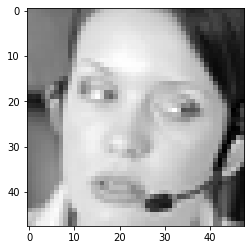

In [9]:
from keras.preprocessing import image
img = image.load_img("dataset/test/angry/im2.png",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [11]:
## scale width/depth/resolution 
## used here so i can load the weight from imagent 
#imagenet is using to classify million of trainded images and compare them with each other 
base_model = tf.keras.applications.EfficientNetB0(input_shape=(48,48,3),include_top=False,weights="imagenet")

16711680/16705208 [==============================] - 5s 0us/step


In [13]:
# Freezing Layers so the weight not be modifyed 

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [15]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5120)              20480     
_________________________________________________________________
dense (Dense)                (None, 32)                163872    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)               

In [17]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [18]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [19]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('Mymodel.h5')

es = EarlyStopping(verbose=1, patience=20)

In [20]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [21]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 50,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/50
359/359 [==============================] - 1271s 4s/step - loss: 1.9108 - accuracy: 0.8549 - precision: 0.2239 - recall: 0.0064 - auc: 0.6118 - f1_score: 0.0120 - val_loss: 1.8162 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6438 - val_f1_score: 0.0000e+00


C:\Users\Lenovo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
359/359 [==============================] - 96s 269ms/step - loss: 1.8374 - accuracy: 0.8570 - precision: 0.2200 - recall: 4.7893e-04 - auc: 0.6321 - f1_score: 9.3760e-04 - val_loss: 1.8101 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6429 - val_f1_score: 0.0000e+00
Epoch 3/50
359/359 [==============================] - 99s 276ms/step - loss: 1.8265 - accuracy: 0.8571 - precision: 0.2500 - recall: 4.3539e-05 - auc: 0.6355 - f1_score: 8.5708e-05 - val_loss: 1.8100 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6432 - val_f1_score: 0.0000e+00
Epoch 4/50
359/359 [==============================] - 100s 279ms/step - loss: 1.8242 - accuracy: 0.8572 - precision: 0.6667 - recall: 8.7078e-05 - auc: 0.6362 - f1_score: 1.7142e-04 - val_loss: 1.8101 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6442 - val_f1_score: 0.0000e+00
Epoch 5/50
359/359 [================

In [30]:
## creating my model
#import h5py
#h5py.File('Mymodel.h5')

C:\Users\Lenovo\anaconda3\envs\env_Sid\lib\site-packages\ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


<HDF5 file "Mymodel.h5" (mode r+)>